In [1]:
import numpy as np
import glob
import os
from models.JetPointNet import PointNetSegmentation


def load_data_from_npz(npz_file):
    data = np.load(npz_file)
    feats = data['feats']  # Shape: (num_samples, 859, 6)
    frac_labels = data['frac_labels']  # Shape: (num_samples, 859)
    tot_labels = data['tot_labels']  # Shape: (num_samples, 859)
    tot_truth_e = data['tot_truth_e']  # Shape: (num_samples, 859) (This is the true total energy deposited by particles into this cell)
    return feats, frac_labels, tot_labels, tot_truth_e

# Setup
os.environ['CUDA_VISIBLE_DEVICES'] = ""  # Disable GPU
model_path = "saved_model/PointNetModel.keras"

TEST_DIR = '/data/mjovanovic/jets/processed_files/2000_events_w_fixed_hits/SavedNpz/test'

model = PointNetSegmentation(num_points=278, num_classes=1)
model.load_weights(model_path)

npz_files = glob.glob(os.path.join(TEST_DIR, '*.npz'))



2024-04-24 13:30:22.767171: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2415919104 exceeds 10% of free system memory.
2024-04-24 13:30:23.202237: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2415919104 exceeds 10% of free system memory.
2024-04-24 13:30:23.594070: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2415919104 exceeds 10% of free system memory.
2024-04-24 13:30:24.146341: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2415919104 exceeds 10% of free system memory.
2024-04-24 13:30:25.525418: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2415919104 exceeds 10% of free system memory.


16/16 [==============================] - 2s 103ms/step
Sample Index:  0
Total number of cells in sample:  60
Predicted Count:  5
True Count:  29
Energy Weighted Accuracy:  0.25135843513474865

Sample Index:  1
Total number of cells in sample:  47
Predicted Count:  2
True Count:  15
Energy Weighted Accuracy:  0.1703383895357322

Sample Index:  2
Total number of cells in sample:  92
Predicted Count:  2
True Count:  83
Energy Weighted Accuracy:  0.10394716254503053

Sample Index:  3
Total number of cells in sample:  105
Predicted Count:  6
True Count:  65
Energy Weighted Accuracy:  0.4915534830802245

Sample Index:  4
Total number of cells in sample:  39
Predicted Count:  39
True Count:  36
Energy Weighted Accuracy:  0.9927638961289836

Sample Index:  5
Total number of cells in sample:  56
Predicted Count:  10
True Count:  1
Energy Weighted Accuracy:  0.9593768814367712

Sample Index:  6
Total number of cells in sample:  95
Predicted Count:  1
True Count:  11
Energy Weighted Accuracy:  0.

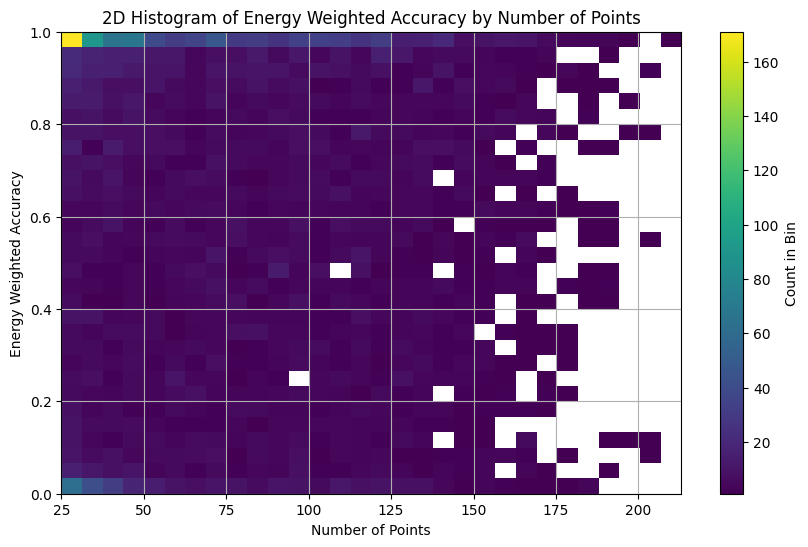

Overall Mean Weighted Accuracy:  0.6161563943759896


In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_energies(predicted_energies, true_energies, coords, types, sample_index):
    fig = plt.figure(figsize=(14, 7))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    ax1.set_title('Predicted Classifications')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax2.set_title('Actual Classifications')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    for i, t in enumerate(types):
        if t == -1:
            continue
        color = 'r' if predicted_energies[i] > 0.5 else 'b'
        marker = 'x' if true_energies[i] > 0.5 else 'o'
        ax1.scatter(coords[i, 0], coords[i, 1], coords[i, 2], color=color, marker=marker)
        ax2.scatter(coords[i, 0], coords[i, 1], coords[i, 2], color=color, marker=marker)

    plt.suptitle(f'Sample {sample_index}')
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1)), ax=[ax1, ax2], shrink=0.5, aspect=20)
    cbar.set_label('Classification (0 or 1)')
    plt.show()

# Data collections
num_points_list = []
accuracies_list = []

# Process each file
for npz_file_idx, npz_file in enumerate(npz_files):
    feats, frac_labels, tot_labels, tot_truth_e = load_data_from_npz(npz_file)
    segmentation_logits = model.predict(feats)
    segmentation_logits = np.squeeze(segmentation_logits, axis=-1)

    for sample_idx in range(len(feats)):
        valid_types = feats[sample_idx][:, -1]
        energies = tot_labels[sample_idx]
        valid_indices = valid_types != 1  # Exclude -1 types for plotting

        energy_types = feats[sample_idx][:, 6]
        coords = feats[sample_idx][valid_indices, :3]
        energy_type_mask = energy_types == 1

        energies_filtered = energies[energy_type_mask]
        predicted_classes = np.where(segmentation_logits[sample_idx] > 0, 1, 0)[energy_type_mask]
        true_classes = np.where(frac_labels[sample_idx] > 0.5, 1, 0)[energy_type_mask]

        correct_predictions = predicted_classes == true_classes
        correct_energy = np.sum(energies_filtered[correct_predictions])
        total_energy = np.sum(energies_filtered)

        energy_weighted_accuracy = correct_energy / (total_energy + 1e-5) if total_energy != 0 else 1

        # Skip invalid data points
        if energy_weighted_accuracy > 1 or energy_weighted_accuracy < 0:
            continue

        # Collect data for 2D histogram
        num_points_list.append(np.sum(energy_type_mask))
        accuracies_list.append(energy_weighted_accuracy)

        print("Sample Index: ", sample_idx)
        print("Total number of cells in sample: ", np.sum(energy_type_mask))
        print("Predicted Count: ", np.sum(predicted_classes))
        print("True Count: ", np.sum(true_classes))
        print("Energy Weighted Accuracy: ", energy_weighted_accuracy)
        print()

# Plotting 2D histogram
plt.figure(figsize=(10, 6))
plt.hist2d(num_points_list, accuracies_list, bins=[30, 30], cmap='viridis', cmin=1)
plt.colorbar(label='Count in Bin')
plt.xlabel('Number of Points')
plt.ylabel('Energy Weighted Accuracy')
plt.title('2D Histogram of Energy Weighted Accuracy by Number of Points')
plt.grid(True)
plt.show()

# Calculate overall mean weighted accuracy
mean_weighted_accuracy = np.mean(accuracies_list)
print("Overall Mean Weighted Accuracy (For more than " ,min_num_points ," points): ", mean_weighted_accuracy)
